# Pregunta 3: Convolutional Neural Network (CNN) en CIFAR.

a) Construya una función que cargue todos los bloques de entrenamiento y pruebas del problema CIFAR generando como salida: (i) dos matrices $X_{tr}$, $Y_{tr}$, correspondientes a las imágenes y etiquetas de entrenamiento, (ii) dos matrices $X_t$ , $Y_t$ , correspondientes a las imágenes y etiquetas de pruebas, y finalmente (iii) dos matrices $X_v$,$Y_v$, correspondientes a imágenes y etiquetas que se usarán como conjunto de validación, es decir para tomar decisiones de diseño acerca del modelo. Este último conjunto debe ser extraı́do desde el conjunto de entrenamiento original y no debe superar las 5000 imágenes.

Se hace un shuffle y se sacan los ultimos 5000 desde el entrenamiento para hacer el conjunto de validación

In [44]:
import pickle
import numpy as np
import os
from scipy.misc import imread
import math
import matplotlib.pyplot as plt
import pydot_ng as pydot 
from IPython.display import Image, display, SVG
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model
from keras.models import load_model

In [3]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_CIFAR_one(filename):
    with open(filename, 'rb') as f:
        #print("f: ",f)
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        Y = np.array(Y)
        return X, Y
    
def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
#     print(len(Xtr))
#     print(len(Ytr))
    #add your Xval
    XY = list(zip(Xtr, Ytr))
    np.random.shuffle(XY)
    Xtr, Ytr = zip(*XY)
    msk = 45000
    Xva = np.array(Xtr[msk:])
    Yva = np.array(Ytr[msk:])   
    Xtr = np.array(Xtr[:msk])        
    Ytr = np.array(Ytr[:msk])
#     print(len(Xtr))
#     print(len(Ytr))
#     print(len(Xva))
#     print(len(Yva))
        
    del X, Y
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
    return Xtr, Ytr, Xva, Yva, Xte, Yte

In [4]:
x_train, y_train, x_val, y_val, x_test, y_test = load_CIFAR10('.')

seria bueno visualizar las imagenes~

b) Prepare subconjuntos de entrenamiento, validación y pruebas normalizando las imágenes de entrenamiento y pruebas, dividiendo las intensidades originales de pixel en cada canal por 255. Es importante recordar que ahora se trabajará con la estructura original de los datos, por lo que es necesario recuperar la forma original de las imágenes del vector en el archivo en que vienen. Además, si desea trabajar con el orden de las dimensiones denominado ’tf’ (por defecto para TensorFlow) deberá hacer realizar la transposición correspondiente. Finalmente, genere una representación adecuada de las salidas deseadas de la red.

Normalizando cada canal por 255

In [5]:
print(x_train[0])
print(x_val[0])
print(x_test[0])

x_train = x_train/255.0
x_val = x_val/255.0
x_test = x_test/255.0

print(x_train[0])
print(x_val[0])
print(x_test[0])

[149 159 160 ...  44  25  29]
[255 255 255 ... 255 255 255]
[158 159 165 ... 124 129 110]
[0.58431373 0.62352941 0.62745098 ... 0.17254902 0.09803922 0.11372549]
[1. 1. 1. ... 1. 1. 1.]
[0.61960784 0.62352941 0.64705882 ... 0.48627451 0.50588235 0.43137255]


Las imagenes se transforman en sus dimensiones originales y las etiquetas se transforman a one-hot vector

In [6]:
x_train = x_train.reshape((x_train.shape[0],3,32,32))
print(x_train.shape)
x_train = x_train.transpose([0, 2, 3, 1]) #only if 'tf' dim-ordering is to be used
x_test = x_test.reshape((x_test.shape[0],3,32,32))
x_test = x_test.transpose([0, 2, 3, 1])#remove if 'th' dim-ordering is to be used
x_val = x_val.reshape((x_val.shape[0],3,32,32))
x_val = x_val.transpose([0, 2, 3, 1])

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

(45000, 3, 32, 32)


In [7]:
print(x_val.shape)

(5000, 32, 32, 3)


c) Defina una CNN con arquitectura $C \times P \times C \times P \times F \times F$. Para ambas capas convolucionales utilice 64 filtros de $3 \times 3$ y funciones de activación ReLu. Para las capas de pooling utilice filtros de $2 \times 2$ con stride 2. Para la capa MLP escondida use 512 neuronas. Genere un esquema lo más compacto posible que muestre los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un forward-pass y el número de parámetros de cada capa.

Definición de arquitectura:
* C: Capa convolucional
* P: Capa de pooling
* F: Cada MLP como las de Feef Forward

In [8]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

In [ ]:
model.save('base_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('base_model.h5')

d) Entrene la CNN definida en c) utilizando SGD. En este dataset, una tasa de aprendizaje “segura” es $\eta = 10^4$ o inferior, pero durante las primeras epochs el entrenamiento resulta demasiado lento. Para resolver el problema aprenderemos a controlar la tasa de aprendizaje utilizada en el entrenamiento. Implemente la siguiente idea: deseamos partir con una tasa de aprendizaje $\eta = 10^3$ y dividir por 2 ese valor cada 10 epochs. Suponga además que no queremos usar una tasa de aprendizaje menor a $\eta = 10^5$. Construya un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de “epochs”, entrene con 25 epochs.



In [9]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

batch_size = 100#??
epochs = 25
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
model_sgd = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), shuffle=True, callbacks=[lrate])

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 175s 4ms/step - loss: 2.1586 - acc: 0.2166 - val_loss: 1.9729 - val_acc: 0.3000
Epoch 2/25
45000/45000 [==============================] - 171s 4ms/step - loss: 1.8742 - acc: 0.3409 - val_loss: 1.7985 - val_acc: 0.3742
Epoch 3/25
45000/45000 [==============================] - 171s 4ms/step - loss: 1.7039 - acc: 0.4060 - val_loss: 1.6355 - val_acc: 0.4182
Epoch 4/25
45000/45000 [==============================] - 173s 4ms/step - loss: 1.5736 - acc: 0.4444 - val_loss: 1.5421 - val_acc: 0.4524
Epoch 5/25
45000/45000 [==============================] - 170s 4ms/step - loss: 1.4909 - acc: 0.4738 - val_loss: 1.4928 - val_acc: 0.4654
Epoch 6/25
45000/45000 [==============================] - 170s 4ms/step - loss: 1.4510 - acc: 0.4899 - val_loss: 1.4633 - val_acc: 0.4676
Epoch 7/25
45000/45000 [==============================] - 170s 4ms/step - loss: 1.4156 - acc: 0.5020 - val_loss: 1.4563 - v

In [10]:
model.save('base_sgd.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('base_sgd.h5')

In [11]:
def plot(hist):
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(1, len(loss) + 1)
    
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(epochs, loss, 'bo-', label = "Training set")
    ax.plot(epochs, val_loss, 'go-', label = "Test set")
    ax.set_title('Loss de CNN')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    #ax.set_ylim(0,2)
    ax.legend(loc="upper right", fancybox= True)

    acc = hist['acc']
    val_acc = hist['val_acc']
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(epochs, np.subtract(1,acc), 'bo-', label = "Training set")
    ax.plot(epochs, np.subtract(1,val_acc), 'go-', label = "Test set")
    ax.set_title('Error de CNN')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    #ax.set_ylim(0,.8)
    ax.legend(loc="upper right", fancybox= True)
    plt.show()

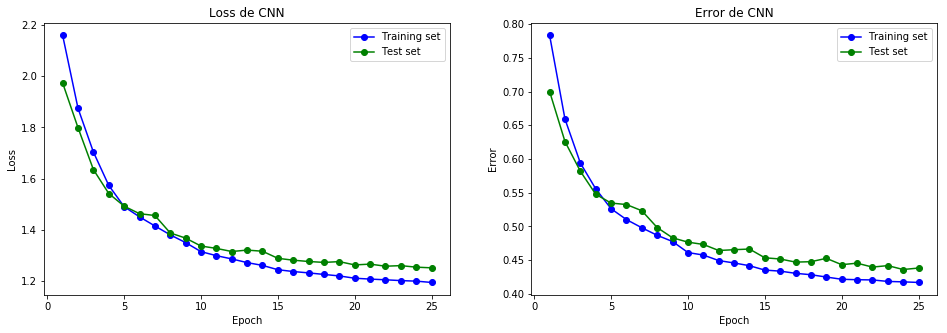

In [12]:
plot(model_sgd.history)

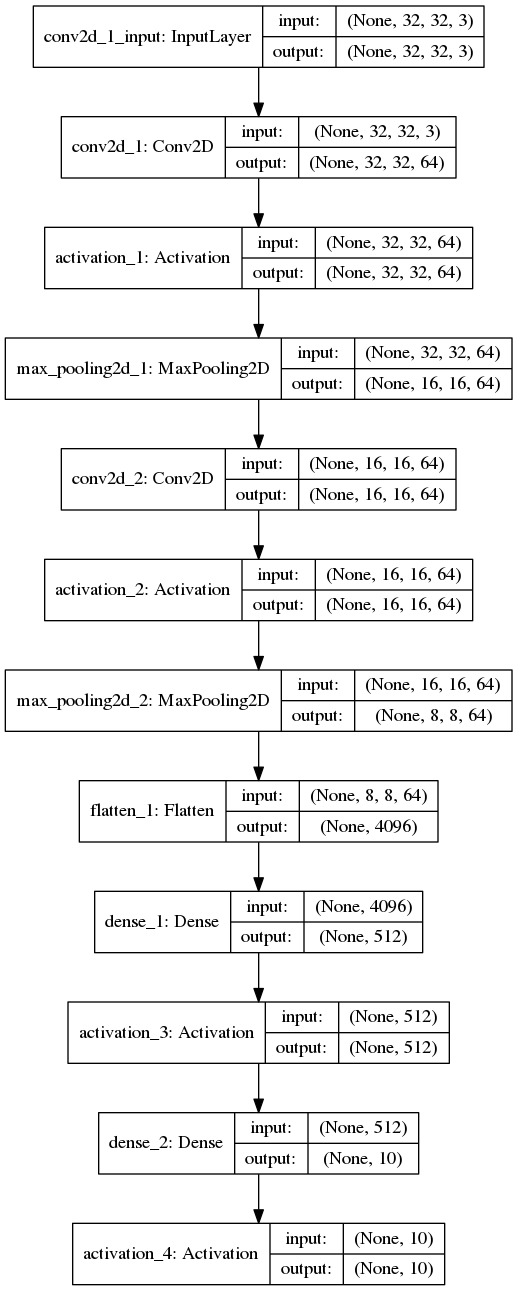

In [21]:
plot_model(model, to_file='model_sgd.png', show_shapes=True)
Image(filename='model_sgd.png')

Evaluand la red en el test set

In [14]:
score_Sgd = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 12s 1ms/step


In [15]:
print("Cross entropy:", score_Sgd[0])
print("Accuracy: ", score_Sgd[1])

Cross entropy: 1.2281566566467286
Accuracy:  0.5658


e) Entrene la CNN definida en c) utilizando RMSProp durante 25 epochs. Elija la función de pérdida más apropiada para este problema. Construya finalmente un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de epochs.

In [16]:
from keras.optimizers import SGD, rmsprop
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy' ,metrics=['acc'])
model_rmsprop = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 175s 4ms/step - loss: 1.6358 - acc: 0.4827 - val_loss: 1.1820 - val_acc: 0.5818
Epoch 2/25
45000/45000 [==============================] - 175s 4ms/step - loss: 1.0693 - acc: 0.6252 - val_loss: 1.0716 - val_acc: 0.6270
Epoch 3/25
45000/45000 [==============================] - 173s 4ms/step - loss: 0.8629 - acc: 0.6982 - val_loss: 0.9480 - val_acc: 0.6722
Epoch 4/25
45000/45000 [==============================] - 173s 4ms/step - loss: 0.6894 - acc: 0.7615 - val_loss: 0.9159 - val_acc: 0.6860
Epoch 5/25
45000/45000 [==============================] - 172s 4ms/step - loss: 0.5390 - acc: 0.8139 - val_loss: 0.9653 - val_acc: 0.6910
Epoch 6/25
45000/45000 [==============================] - 172s 4ms/step - loss: 0.3990 - acc: 0.8624 - val_loss: 1.0375 - val_acc: 0.6854
Epoch 7/25
45000/45000 [==============================] - 172s 4ms/step - loss: 0.2783 - acc: 0.9054 - val_loss: 1.2389 - v

In [19]:
model.save('base_msprop.h5')  # creates a HDF5 file 'my_model.h5'

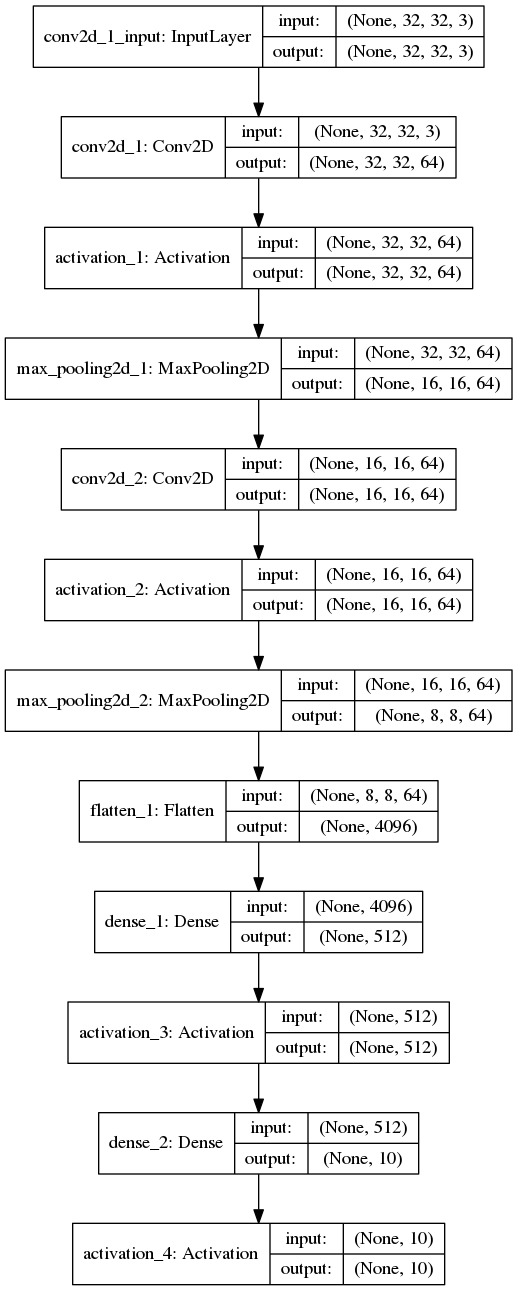

In [22]:
plot_model(model, to_file='model_msprop.png', show_shapes=True)
Image(filename='model_msprop.png')

In [17]:
score_msprop = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 12s 1ms/step


In [18]:
print("Cross entropy:", score_msprop[0])
print("Accuracy: ", score_msprop[1])

Cross entropy: 2.5480877639770507
Accuracy:  0.7053


f) Evalúe el efecto de modificar el tamaño de los filtros (de convolución) reportando la sensibilidad del error de pruebas a estos cambios en dos tipos de arquitecturas, una profunda y otra no. Presente un gráfico o tabla resumen. Por simplicidad entre durante sólo 15-20 epochs.

aumnetar el campo de visión de una neurona

In [23]:
#Shallow network rmsprop
nc = 5
model_filtro_5 = Sequential()
model_filtro_5.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_filtro_5.add(Activation('relu'))
model_filtro_5.add(MaxPooling2D(pool_size=(2, 2)))
model_filtro_5.add(Flatten())
model_filtro_5.add(Dense(512))
model_filtro_5.add(Activation('relu'))
model_filtro_5.add(Dense(10))
model_filtro_5.add(Activation('softmax'))

In [25]:
opt = rmsprop(lr=0.001, decay=1e-6)
model_filtro_5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 18
model_fil_5 = model_filtro_5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/18
45000/45000 [==============================] - 182s 4ms/step - loss: 1.0323 - acc: 0.6445 - val_loss: 1.0674 - val_acc: 0.6362
Epoch 2/18
45000/45000 [==============================] - 188s 4ms/step - loss: 0.8401 - acc: 0.7095 - val_loss: 1.0308 - val_acc: 0.6536
Epoch 3/18
45000/45000 [==============================] - 187s 4ms/step - loss: 0.6795 - acc: 0.7648 - val_loss: 1.0566 - val_acc: 0.6610
Epoch 4/18
45000/45000 [==============================] - 184s 4ms/step - loss: 0.5334 - acc: 0.8177 - val_loss: 1.0995 - val_acc: 0.6626
Epoch 5/18
45000/45000 [==============================] - 203s 5ms/step - loss: 0.4019 - acc: 0.8648 - val_loss: 1.2059 - val_acc: 0.6614
Epoch 6/18
45000/45000 [==============================] - 179s 4ms/step - loss: 0.2955 - acc: 0.9008 - val_loss: 1.3652 - val_acc: 0.6554
Epoch 7/18
45000/45000 [==============================] - 182s 4ms/step - loss: 0.2136 - acc: 0.9294 - val_loss: 1.4218 - v

In [26]:
model_filtro_5.save('shallow_net_5_rmsprop.h5')  # creates a HDF5 file 'my_model.h5'

In [27]:
score_shallow_net_5_msprop = model_filtro_5.evaluate(x_test, y_test)

10000/10000 [==============================] - 13s 1ms/step


In [28]:
print("Cross entropy:", score_shallow_net_5_msprop[0])
print("Accuracy: ", score_shallow_net_5_msprop[1])

Cross entropy: 2.4734953501701353
Accuracy:  0.6633


In [40]:
#Shallow network rmsprop
nc = 3
model_shadow_filtro_3 = Sequential()
model_shadow_filtro_3.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_shadow_filtro_3.add(Activation('relu'))
model_shadow_filtro_3.add(MaxPooling2D(pool_size=(2, 2)))
model_shadow_filtro_3.add(Flatten())
model_shadow_filtro_3.add(Dense(512))
model_shadow_filtro_3.add(Activation('relu'))
model_shadow_filtro_3.add(Dense(10))
model_shadow_filtro_3.add(Activation('softmax'))
opt = rmsprop(lr=0.001, decay=1e-6)
model_shadow_filtro_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 18
shallow_net_3_msprop = model_shadow_filtro_3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)
model_shadow_filtro_3.save('shallow_net_3_rmsprop.h5')  # creates a HDF5 file 'my_model.h5'
model_shadow_filtro_3.save_weights('shallow_net_3_rmsprop_weights.h5')

Train on 45000 samples, validate on 5000 samples
Epoch 1/18
45000/45000 [==============================] - 165s 4ms/step - loss: 1.6116 - acc: 0.4488 - val_loss: 1.3686 - val_acc: 0.5244
Epoch 2/18
45000/45000 [==============================] - 165s 4ms/step - loss: 1.1849 - acc: 0.5846 - val_loss: 1.0948 - val_acc: 0.6254
Epoch 3/18
45000/45000 [==============================] - 161s 4ms/step - loss: 1.0036 - acc: 0.6507 - val_loss: 1.1209 - val_acc: 0.6100
Epoch 4/18
45000/45000 [==============================] - 160s 4ms/step - loss: 0.8619 - acc: 0.7007 - val_loss: 1.0169 - val_acc: 0.6522
Epoch 5/18
45000/45000 [==============================] - 159s 4ms/step - loss: 0.7368 - acc: 0.7429 - val_loss: 1.0479 - val_acc: 0.6394
Epoch 6/18
45000/45000 [==============================] - 159s 4ms/step - loss: 0.6219 - acc: 0.7846 - val_loss: 1.0808 - val_acc: 0.6458
Epoch 7/18
45000/45000 [==============================] - 159s 4ms/step - loss: 0.5132 - acc: 0.8246 - val_loss: 1.0719 - v

In [41]:
score_shallow_net_3_msprop = model_shadow_filtro_3.evaluate(x_test, y_test)
print("Cross entropy:", score_shallow_net_3_msprop[0])
print("Accuracy: ", score_shallow_net_3_msprop[1])

10000/10000 [==============================] - 10s 1ms/step
Cross entropy: 1.9520305186271667
Accuracy:  0.6729


In [32]:
#Deep network rmsprop
nc = 5
model_deep_filtro_5 = Sequential()
model_deep_filtro_5.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_deep_filtro_5.add(Activation('relu'))
model_deep_filtro_5.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_filtro_5.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_deep_filtro_5.add(Activation('relu'))
model_deep_filtro_5.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_filtro_5.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_deep_filtro_5.add(Activation('relu'))
model_deep_filtro_5.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_filtro_5.add(Flatten())
model_deep_filtro_5.add(Dense(512))
model_deep_filtro_5.add(Activation('relu'))
model_deep_filtro_5.add(Dense(10))
model_deep_filtro_5.add(Activation('softmax'))
opt = rmsprop(lr=0.001, decay=1e-6)
model_deep_filtro_5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 18
score_deep_net_5_msprop = model_deep_filtro_5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)
model_deep_filtro_5.save('deep_net_5_rmsprop.h5')  # creates a HDF5 file 'my_model.h5'

Train on 45000 samples, validate on 5000 samples
Epoch 1/18
45000/45000 [==============================] - 394s 9ms/step - loss: 1.7480 - acc: 0.3738 - val_loss: 1.3724 - val_acc: 0.5180
Epoch 2/18
45000/45000 [==============================] - 405s 9ms/step - loss: 1.2438 - acc: 0.5628 - val_loss: 1.1704 - val_acc: 0.5914
Epoch 3/18
45000/45000 [==============================] - 393s 9ms/step - loss: 1.0202 - acc: 0.6412 - val_loss: 1.0331 - val_acc: 0.6390
Epoch 4/18
45000/45000 [==============================] - 440s 10ms/step - loss: 0.8593 - acc: 0.7008 - val_loss: 1.0028 - val_acc: 0.6578
Epoch 5/18
45000/45000 [==============================] - 400s 9ms/step - loss: 0.7251 - acc: 0.7458 - val_loss: 1.0239 - val_acc: 0.6528
Epoch 6/18
45000/45000 [==============================] - 390s 9ms/step - loss: 0.6067 - acc: 0.7896 - val_loss: 0.9730 - val_acc: 0.6850
Epoch 7/18
45000/45000 [==============================] - 393s 9ms/step - loss: 0.5037 - acc: 0.8258 - val_loss: 1.2049 - 

In [33]:
scoree_deep_net_5_msprop = model_deep_filtro_5.evaluate(x_test, y_test)
print("Cross entropy:", scoree_deep_net_5_msprop[0])
print("Accuracy: ", scoree_deep_net_5_msprop[1])

10000/10000 [==============================] - 30s 3ms/step
Cross entropy: 1.998617034816742
Accuracy:  0.6873


In [34]:
#Deep network rmsprop
nc = 3
model_deep_filtro_3 = Sequential()
model_deep_filtro_3.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_deep_filtro_3.add(Activation('relu'))
model_deep_filtro_3.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_filtro_3.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_deep_filtro_3.add(Activation('relu'))
model_deep_filtro_3.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_filtro_3.add(Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
model_deep_filtro_3.add(Activation('relu'))
model_deep_filtro_3.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_filtro_3.add(Flatten())
model_deep_filtro_3.add(Dense(512))
model_deep_filtro_3.add(Activation('relu'))
model_deep_filtro_3.add(Dense(10))
model_deep_filtro_3.add(Activation('softmax'))
opt = rmsprop(lr=0.001, decay=1e-6)
model_deep_filtro_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 18
deep_net_3_msprop = model_deep_filtro_3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)
model_deep_filtro_3.save('deep_net_5_rmsprop.h5')  # creates a HDF5 file 'my_model.h5'

Train on 45000 samples, validate on 5000 samples
Epoch 1/18
45000/45000 [==============================] - 180s 4ms/step - loss: 1.6520 - acc: 0.4073 - val_loss: 1.4982 - val_acc: 0.5054
Epoch 2/18
45000/45000 [==============================] - 185s 4ms/step - loss: 1.1689 - acc: 0.5896 - val_loss: 1.1684 - val_acc: 0.5994
Epoch 3/18
45000/45000 [==============================] - 185s 4ms/step - loss: 0.9540 - acc: 0.6676 - val_loss: 0.9284 - val_acc: 0.6776
Epoch 4/18
45000/45000 [==============================] - 184s 4ms/step - loss: 0.8159 - acc: 0.7168 - val_loss: 0.9041 - val_acc: 0.6892
Epoch 5/18
45000/45000 [==============================] - 188s 4ms/step - loss: 0.7061 - acc: 0.7544 - val_loss: 0.8312 - val_acc: 0.7116
Epoch 6/18
45000/45000 [==============================] - 184s 4ms/step - loss: 0.6102 - acc: 0.7861 - val_loss: 0.8174 - val_acc: 0.7226
Epoch 7/18
45000/45000 [==============================] - 191s 4ms/step - loss: 0.5181 - acc: 0.8222 - val_loss: 0.9312 - v

In [35]:
score_deep_net_3_msprop = model_deep_filtro_3.evaluate(x_test, y_test)
print("Cross entropy:", score_deep_net_3_msprop[0])
print("Accuracy: ", score_deep_net_3_msprop[1])

10000/10000 [==============================] - 14s 1ms/step
Cross entropy: 1.6620582500457763
Accuracy:  0.7354


	 Shadow network 3


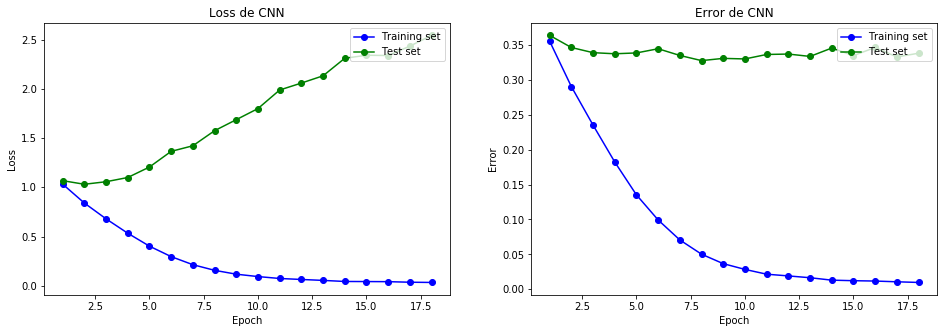

	 Shadow network 5


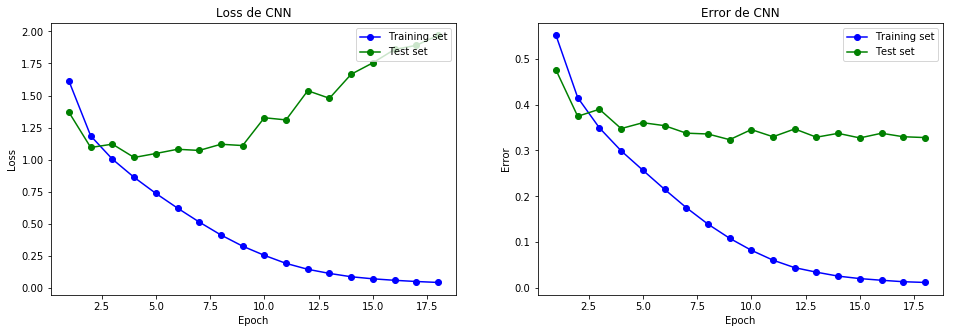

	 Deep network 3


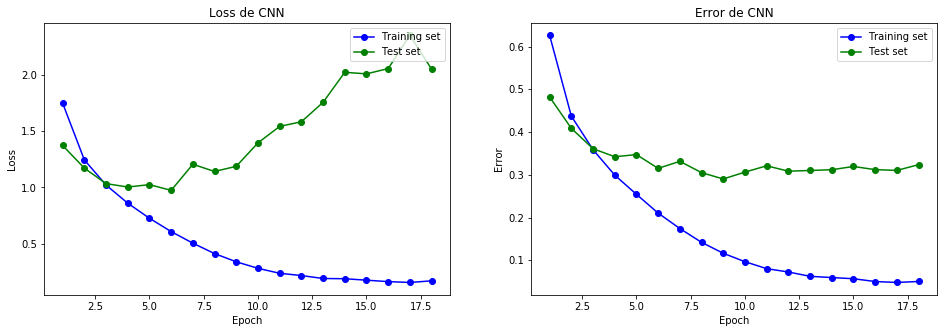

	 Deep network 5


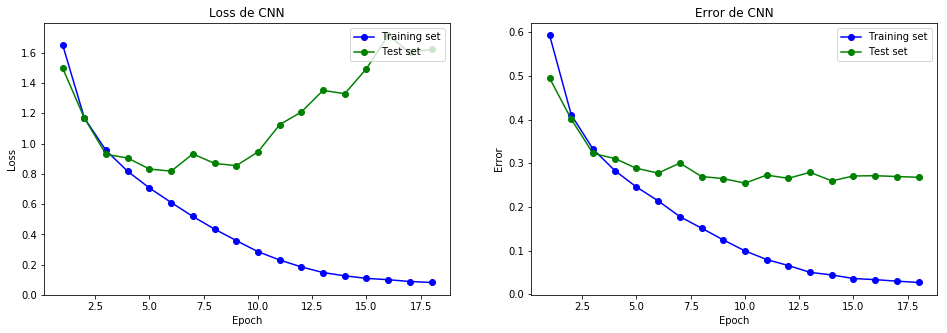

In [48]:
print("\t Shadow network 3")
plot(model_fil_5.history)
#shallow_net_3_msprop = load_model('shallow_net_3_rmsprop_weights.h5')
print("\t Shadow network 5")
plot(shallow_net_3_msprop.history)
print("\t Deep network 3")
plot(score_deep_net_5_msprop.history)
print("\t Deep network 5")
plot(deep_net_3_msprop.history)

g) Se ha sugerido que la práctica bastante habitual de continuar una capa convolucional con una capa de pooling puede generar una reducción prematura de las dimensiones del patrón de entrada. Experimente con una arquitectura del tipo $C \times C \times P \times C \times C \times P \times F \times F$. Use 64 filtros para las primeras 2 capas convolucionales y 128 para las últimas dos. Reflexione sobre qué le parece más sensato: ¿mantener el tamaño de los filtros usados anteriormente? o ¿usar filtros más grandes en la segunda capa convolucional y más pequeños en la primera? o ¿usar filtros más pequeños en la segunda capa convolucional y más grandes en la primera? Hint: con esta nueva arquitectura debiese superar el 70% de accuracy (de validación/test) antes de 5 epochs, pero la arquitectura es más sensible a overfitting por lo que podrı́a ser conveniente agregar un regularizador. Como resultado final de esta actividad gráficque los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).

In [49]:
model_2c = Sequential()
#C x C x P
model_2c.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_2c.add(Activation('relu'))
model_2c.add(Conv2D(64, (3, 3), padding='same'))
model_2c.add(Activation('relu'))
model_2c.add(MaxPooling2D(pool_size=(2, 2)))
model_2c.add(Dropout(0.25))
#C x C x P
model_2c.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_2c.add(Activation('relu'))
model_2c.add(Conv2D(128, (3, 3), padding='same'))
model_2c.add(Activation('relu'))
model_2c.add(MaxPooling2D(pool_size=(2, 2)))
model_2c.add(Dropout(0.25))
#F x F
model_2c.add(Flatten())
model_2c.add(Dense(512, activation='relu'))
model_2c.add(Dropout(0.25))
model_2c.add(Dense(10, activation='softmax'))
model_2c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_30 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 128)       73856     
__________

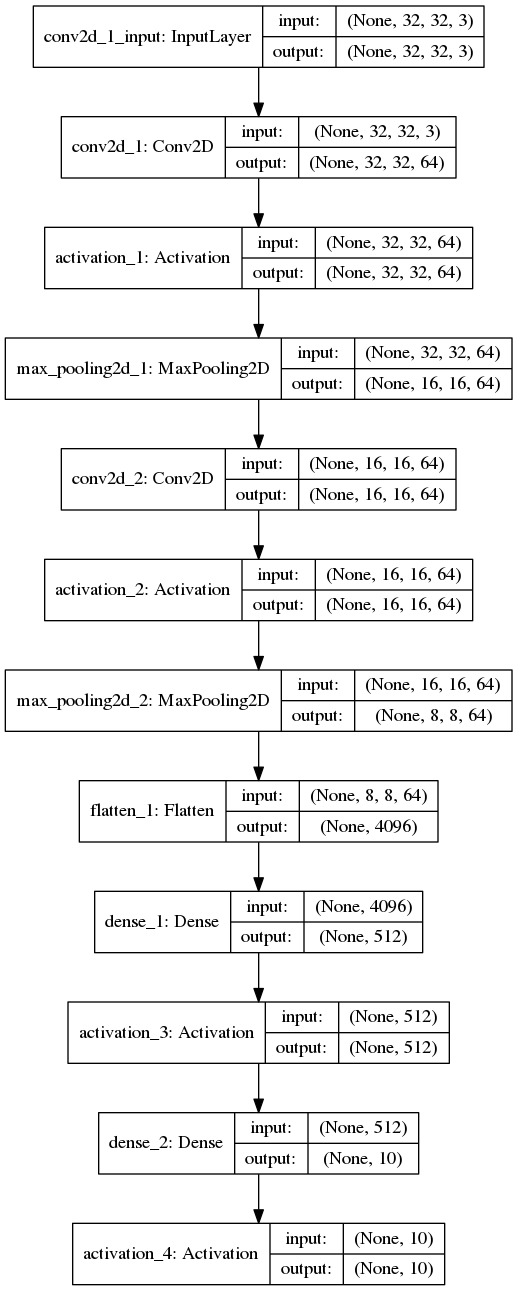

In [50]:
plot_model(model, to_file='model_2c_rmsprop.png', show_shapes=True)
Image(filename='model_2c_rmsprop.png')

In [52]:
opt = rmsprop(lr=0.001, decay=1e-6)
model_2c.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 25
model_2c_rmsprop = model_2c.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)
model_2c.save('model_2c_rmsprop.h5')  # creates a HDF5 file 'my_model.h5'

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 979s 22ms/step - loss: 0.9063 - acc: 0.6911 - val_loss: 0.8249 - val_acc: 0.7182
Epoch 2/25
45000/45000 [==============================] - 1005s 22ms/step - loss: 0.7589 - acc: 0.7381 - val_loss: 0.7620 - val_acc: 0.7444
Epoch 3/25
45000/45000 [==============================] - 995s 22ms/step - loss: 0.6742 - acc: 0.7714 - val_loss: 0.7145 - val_acc: 0.7620
Epoch 4/25
45000/45000 [==============================] - 971s 22ms/step - loss: 0.6184 - acc: 0.7914 - val_loss: 0.7224 - val_acc: 0.7636
Epoch 5/25
45000/45000 [==============================] - 998s 22ms/step - loss: 0.5772 - acc: 0.8050 - val_loss: 0.7188 - val_acc: 0.7714
Epoch 6/25
45000/45000 [==============================] - 983s 22ms/step - loss: 0.5662 - acc: 0.8153 - val_loss: 0.7654 - val_acc: 0.7562
Epoch 7/25
45000/45000 [==============================] - 967s 21ms/step - loss: 0.5468 - acc: 0.8212 - val_loss: 0.

In [53]:
score_model_2c_msprop = model_2c.evaluate(x_test, y_test)
print("Cross entropy:", score_model_2c_msprop[0])
print("Accuracy: ", score_model_2c_msprop[1])

10000/10000 [==============================] - 69s 7ms/step
Cross entropy: 1.118525070476532
Accuracy:  0.7585


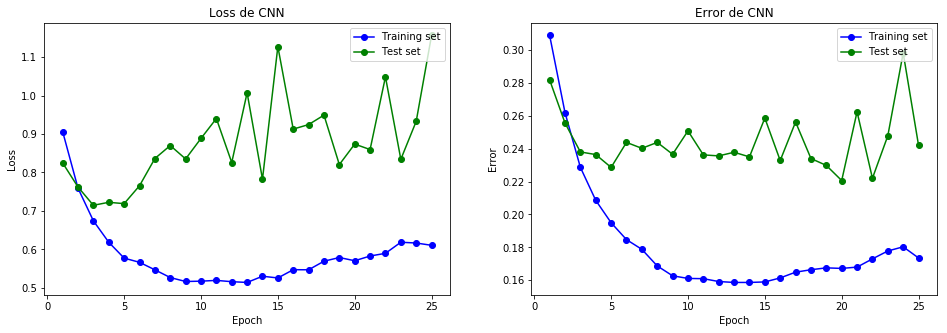

In [54]:
plot(model_2c_rmsprop.history)

Se prueba en el primer par de capas con 128 filtros para las dos primeras capas convolucionales y 64 para otras dos capas cnvolucionales

In [58]:
model_2c_128_64 = Sequential()
#C x C x P
model_2c_128_64.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_2c_128_64.add(Activation('relu'))
model_2c_128_64.add(Conv2D(128, (3, 3), padding='same'))
model_2c_128_64.add(Activation('relu'))
model_2c_128_64.add(MaxPooling2D(pool_size=(2, 2)))
model_2c_128_64.add(Dropout(0.25))
#C x C x P
model_2c_128_64.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_2c_128_64.add(Activation('relu'))
model_2c_128_64.add(Conv2D(64, (3, 3), padding='same'))
model_2c_128_64.add(Activation('relu'))
model_2c_128_64.add(MaxPooling2D(pool_size=(2, 2)))
model_2c_128_64.add(Dropout(0.25))
#F x F
model_2c_128_64.add(Flatten())
model_2c_128_64.add(Dense(512, activation='relu'))
model_2c_128_64.add(Dropout(0.25))
model_2c_128_64.add(Dense(10, activation='softmax'))
model_2c_128_64.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_37 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
activation_38 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 64)        73792     
__________

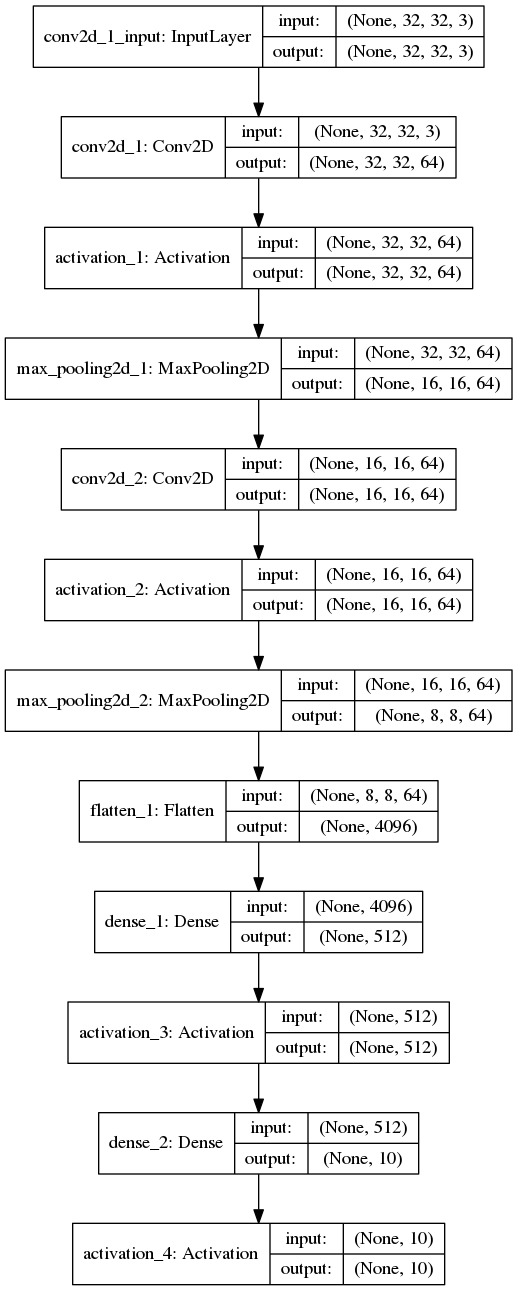

In [59]:
plot_model(model, to_file='model_2c_128_64_rmsprop.png', show_shapes=True)
Image(filename='model_2c_128_64_rmsprop.png')

In [ ]:
opt = rmsprop(lr=0.001, decay=1e-6)
model_2c_128_64.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
epochs = 25
model_2c_128_64_rmsprop = model_2c_128_64.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),shuffle=True)
model_2c_128_64.save('model_2c_128_164_rmsprop.h5')  # creates a HDF5 file 'my_model.h5'

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 1727s 38ms/step - loss: 1.7547 - acc: 0.3752 - val_loss: 1.2983 - val_acc: 0.5460
Epoch 2/25
45000/45000 [==============================] - 1685s 37ms/step - loss: 1.1652 - acc: 0.5920 - val_loss: 1.0080 - val_acc: 0.6530
Epoch 3/25
45000/45000 [==============================] - 1675s 37ms/step - loss: 0.9198 - acc: 0.6782 - val_loss: 0.9311 - val_acc: 0.6802
Epoch 4/25
45000/45000 [==============================] - 1675s 37ms/step - loss: 0.7785 - acc: 0.7308 - val_loss: 0.9742 - val_acc: 0.6806
Epoch 5/25
45000/45000 [==============================] - 1685s 37ms/step - loss: 0.6860 - acc: 0.7644 - val_loss: 0.7721 - val_acc: 0.7398
Epoch 6/25
45000/45000 [==============================] - 1680s 37ms/step - loss: 0.6185 - acc: 0.7883 - val_loss: 0.8032 - val_acc: 0.7300
Epoch 7/25
45000/45000 [==============================] - 1671s 37ms/step - loss: 0.5609 - acc: 0.8102 - val_lo

In [ ]:
score_model_2c_128_64_msprop = model_2c_128_64.evaluate(x_test, y_test)
print("Cross entropy:", score_model_2c_128_64_msprop[0])
print("Accuracy: ", score_model_128_64_2c_msprop[1])